In the previous notebook, we trained a model to classify music. Now, we’ll explore what happens when we vary the training hyperparameters, but train each model to the same validation **accuracy target**. We will consider:

-   how much *time* it takes to achieve that accuracy target (“time to accuracy”)
-   how much *energy* it takes to achieve that accuracy target (“energy to accuracy”)
-   and the *test accuracy* for the model, given that it is trained to the specified validation accuracy target

``` python
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
```

``` python
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import tensorflow.keras.backend as K
```

## Loading Data

Here, we’ll load the processed data defined in the previous notebook

``` python
Xtr_scale = np.load('/kaggle/input/ml-energy/uiowa_std_scale_train_data.npy')
ytr = np.load('/kaggle/input/ml-energy/uiowa_permuted_train_labels.npy')
Xts_scale = np.load('/kaggle/input/ml-energy/uiowa_std_scale_test_data.npy')
yts = np.load('/kaggle/input/ml-energy/uiowa_test_labels.npy')
```

``` python
# TODO -  get basic details of the data
# compute these values from the data, don't hard-code them
n_tr    = Xtr_scale.shape[0]
n_ts    = Xts_scale.shape[0]
n_feat  = Xtr_scale.shape[1]
n_class = len(np.unique(ytr))
```

``` python
# now print those details
print("Num training= %d" % n_tr)
print("Num test=     %d" % n_ts)
print("Num features= %d" % n_feat)
print("Num classes=  %d" % n_class)
```

    Num training= 66247
    Num test=     14904
    Num features= 120
    Num classes=  10

``` python
def get_model(num_units = 256):
    model = Sequential()
    model.add(Input((n_feat,)))
    model.add(Dense(num_units, activation = 'sigmoid'))
    model.add(Dense(n_class, activation = 'softmax'))
    return model
```

#### Energy consumption

To do this, first we will need some way to measure the energy used to train the model. We will use [Zeus](https://ml.energy/zeus/overview/), a Python package developed by researchers at the University of Michigan, to measure the GPU energy consumption.

**Note**: if you are running this experiment in a CPU-only runtime, you should skip this section on energy comsumption. Continue with the ” `TrainToAccuracy` callback” section.

First, install the package:

``` python
!pip install zeus-ml
```

    Collecting zeus-ml
      Downloading zeus_ml-0.8.2-py3-none-any.whl.metadata (9.7 kB)
    Requirement already satisfied: numpy in /opt/conda/lib/python3.10/site-packages (from zeus-ml) (1.26.4)
    Requirement already satisfied: pandas in /opt/conda/lib/python3.10/site-packages (from zeus-ml) (2.1.4)
    Requirement already satisfied: scikit-learn in /opt/conda/lib/python3.10/site-packages (from zeus-ml) (1.2.2)
    Requirement already satisfied: nvidia-ml-py in /opt/conda/lib/python3.10/site-packages (from zeus-ml) (11.495.46)
    Requirement already satisfied: pydantic in /opt/conda/lib/python3.10/site-packages (from zeus-ml) (2.5.3)
    Requirement already satisfied: rich in /opt/conda/lib/python3.10/site-packages (from zeus-ml) (13.7.0)
    Collecting tyro (from zeus-ml)
      Downloading tyro-0.7.3-py3-none-any.whl.metadata (7.7 kB)
    Requirement already satisfied: python-dateutil>=2.8.2 in /opt/conda/lib/python3.10/site-packages (from pandas->zeus-ml) (2.9.0.post0)
    Requirement already satisfied: pytz>=2020.1 in /opt/conda/lib/python3.10/site-packages (from pandas->zeus-ml) (2023.3.post1)
    Requirement already satisfied: tzdata>=2022.1 in /opt/conda/lib/python3.10/site-packages (from pandas->zeus-ml) (2023.4)
    Requirement already satisfied: annotated-types>=0.4.0 in /opt/conda/lib/python3.10/site-packages (from pydantic->zeus-ml) (0.6.0)
    Requirement already satisfied: pydantic-core==2.14.6 in /opt/conda/lib/python3.10/site-packages (from pydantic->zeus-ml) (2.14.6)
    Requirement already satisfied: typing-extensions>=4.6.1 in /opt/conda/lib/python3.10/site-packages (from pydantic->zeus-ml) (4.9.0)
    Requirement already satisfied: markdown-it-py>=2.2.0 in /opt/conda/lib/python3.10/site-packages (from rich->zeus-ml) (3.0.0)
    Requirement already satisfied: pygments<3.0.0,>=2.13.0 in /opt/conda/lib/python3.10/site-packages (from rich->zeus-ml) (2.17.2)
    Requirement already satisfied: scipy>=1.3.2 in /opt/conda/lib/python3.10/site-packages (from scikit-learn->zeus-ml) (1.11.4)
    Requirement already satisfied: joblib>=1.1.1 in /opt/conda/lib/python3.10/site-packages (from scikit-learn->zeus-ml) (1.3.2)
    Requirement already satisfied: threadpoolctl>=2.0.0 in /opt/conda/lib/python3.10/site-packages (from scikit-learn->zeus-ml) (3.2.0)
    Requirement already satisfied: docstring-parser>=0.14.1 in /opt/conda/lib/python3.10/site-packages (from tyro->zeus-ml) (0.15)
    Collecting shtab>=1.5.6 (from tyro->zeus-ml)
      Downloading shtab-1.7.1-py3-none-any.whl.metadata (7.3 kB)
    Requirement already satisfied: mdurl~=0.1 in /opt/conda/lib/python3.10/site-packages (from markdown-it-py>=2.2.0->rich->zeus-ml) (0.1.2)
    Requirement already satisfied: six>=1.5 in /opt/conda/lib/python3.10/site-packages (from python-dateutil>=2.8.2->pandas->zeus-ml) (1.16.0)
    Downloading zeus_ml-0.8.2-py3-none-any.whl (192 kB)
    [2K   [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m192.6/192.6 kB[0m [31m1.8 MB/s[0m eta [36m0:00:00[0ma [36m0:00:01[0m
    [?25hDownloading tyro-0.7.3-py3-none-any.whl (79 kB)
    [2K   [90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━[0m [32m79.8/79.8 kB[0m [31m5.1 MB/s[0m eta [36m0:00:00[0m
    [?25hDownloading shtab-1.7.1-py3-none-any.whl (14 kB)
    Installing collected packages: shtab, tyro, zeus-ml
    Successfully installed shtab-1.7.1 tyro-0.7.3 zeus-ml-0.8.2

Then, import it, and tell it to monitor your GPU:

``` python
from zeus.monitor import ZeusMonitor

monitor = ZeusMonitor()
```

    [2024-04-01 03:13:57,891] [zeus.monitor.energy](energy.py:157) Monitoring GPU indices [0, 1].

When you want to measure GPU energy usage, you will:

-   start a “monitoring window”
-   do your GPU-intensive computation (e.g. call `model.fit`)
-   stop the “monitoring window”

and then you can get the time and total energy used by the GPU in the monitoring window.

Try it now - this will just continue fitting whatever `model` is currently in scope from previous cells:

``` python
# monitor.begin_window("test")

model = get_model()

opt = optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer = opt, loss = loss_fn, metrics = ['accuracy'])

model.fit(Xtr_scale, ytr, epochs=5)
measurement = monitor.end_window("test")
print("Measured time (s)  :" , measurement.time)
print("Measured energy (J):" , measurement.total_energy)
```

    Epoch 1/5
    [1m  96/2071[0m [37m━━━━━━━━━━━━━━━━━━━━[0m [1m3s[0m 2ms/step - accuracy: 0.5852 - loss: 1.3893

    WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
    I0000 00:00:1711941733.362978      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    [1m2071/2071[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 2ms/step - accuracy: 0.8764 - loss: 0.4349
    Epoch 2/5
    [1m2071/2071[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 2ms/step - accuracy: 0.9852 - loss: 0.0584
    Epoch 3/5
    [1m2071/2071[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 2ms/step - accuracy: 0.9911 - loss: 0.0326
    Epoch 4/5
    [1m2071/2071[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 2ms/step - accuracy: 0.9942 - loss: 0.0213
    Epoch 5/5
    [1m2071/2071[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 2ms/step - accuracy: 0.9953 - loss: 0.0162
    Measured time (s)  : 491.52967166900635
    Measured energy (J): 26128.059

#### `TrainToAccuracy` callback

Next, we need a way to train a model until we achieve our desired validation accuracy. We will [write a callback function](https://www.tensorflow.org/guide/keras/writing_your_own_callbacks) following these specifications:

-   It will be called `TrainToAccuracy` and will accept two arguments: a `threshold` and a `patience` value.
-   If the model’s validation accuracy is higher than the `threshold` for `patience` epochs in a row, stop training.
-   In the `on_epoch_end` function, which will be called at the end of every epoch during training, you should get the current validation accuracy using `currect_acc = logs.get("val_accuracy")`. Then, set `self.model.stop_training = True` if the condition above is met.
-   The default values of `threshold` and `patience` are given below, but other values may be passed as arguments at runtime.

Then, when you call `model.fit()`, you will add the `TrainToAccuracy` callback as in

    callbacks=[TrainToAccuracy(threshold=0.98, patience=5)]

``` python
# TODO - write a callback function
class TrainToAccuracy(callbacks.Callback):

    def __init__(self, threshold=0.9, patience=3):
        self.threshold = threshold  # the desired accuracy threshold
        self.patience = patience # how many epochs to wait once hitting the threshold
        self.last_change_epoch = -1

    def on_epoch_end(self, epoch, logs=None):
        current_acc = logs.get("val_accuracy")
        if(current_acc>self.threshold):
          if(epoch - self.last_change_epoch>=self.patience):
            self.model.stop_training = True
        else:
          self.last_change_epoch = epoch
        return
```

Try it! run the following cell to test your `TrainToAccuracy` callback. (This will just continue fitting whatever `model` is currently in scope.)

``` python
model.fit(Xtr_scale, ytr, epochs=100, validation_split = 0.2, callbacks=[TrainToAccuracy(threshold=0.95, patience=5)])
```

    Epoch 1/100
    [1m1657/1657[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m5s[0m 3ms/step - accuracy: 0.9966 - loss: 0.0126 - val_accuracy: 0.9972 - val_loss: 0.0105
    Epoch 2/100
    [1m1657/1657[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 2ms/step - accuracy: 0.9976 - loss: 0.0099 - val_accuracy: 0.9965 - val_loss: 0.0105
    Epoch 3/100
    [1m1657/1657[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 2ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.9960 - val_loss: 0.0110
    Epoch 4/100
    [1m1657/1657[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 2ms/step - accuracy: 0.9976 - loss: 0.0080 - val_accuracy: 0.9968 - val_loss: 0.0096
    Epoch 5/100
    [1m1657/1657[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 2ms/step - accuracy: 0.9978 - loss: 0.0075 - val_accuracy: 0.9967 - val_loss: 0.0099





    <keras.src.callbacks.history.History at 0x7a1d8c5159c0>

Your model shouldn’t *really* train for 100 epochs - it should stop training as soon as 95% validation accuracy is achieved for 5 epochs in a row! (Your “test” is not graded, you may change the `threshold` and `patience` values in this “test” call to `model.fit` in order to check your work.)

Note that since we are now using the validation set performance to *decide* when to stop training the model, we are no longer “allowed” to pass the test set as `validation_data`. The test set must never be used to make decisions during the model training process - only for evaluation of the final model. Instead, we specify that 20% of the training data should be held out as a validation set, and that is the validation accuracy that is used to determine when to stop training.

### See how TTA/ETA varies with learning rate, batch size

Now, you will repeat your model preparation and fitting code - with your new `TrainToAccuracy` callback - but in a loop. First, you will iterate over different learning rates.

In each iteration of each loop, you will prepare a model (with the appropriate training hyperparameters) and train it until:

-   either it has achieved **0.95 accuracy for 3 epoches in a row** on a 20% validation subset of the training data,
-   or, it has trained for 500 epochs

whichever comes FIRST.

For each model, you will record:

-   the training hyperparameters (learning rate, batch size)
-   the number of epochs of training needed to achieve the target validation accuracy
-   the accuracy on the *test* data (not the validation data!). After fitting the model, use `model.evaluate` and pass the scaled *test* data to get the test loss and test accuracy
-   **GPU runtime**: the GPU energy and time to train the model to the desired validation accuracy, as computed by a `zeus-ml` measurement window that starts just before `model.fit` and ends just after `model.fit`.
-   **CPU runtime**: the time to train the model to the desired validation accuracy, as computed by the difference in `time.time()` just before `model.fit` and just after `model.fit`.

``` python

# TODO - iterate over learning rates and get TTA/ETA

# default learning rate and batch size -
batch_size = 128

acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
metrics_vs_lr = []
for lr in [0.0001, 0.001, 0.01, 0.1, 1.0]:
    # TODO - set up model, including appropriate optimizer hyperparameters
    model_test =  get_model()
    opt = optimizers.Adam(learning_rate=lr)
    model_test.compile(optimizer = opt, loss = loss_fn, metrics = ['accuracy'])

    # start measurement
    # if on GPU runtime
    try:
        monitor.begin_window("model_train")
    # if on GPU runtime, but last measurement window is still running
    except ValueError:
        _ = monitor.end_window("model_train")
        monitor.begin_window("model_train")
    # if on CPU runtime
    except NameError:
        start_time = time.time()


    # TODO - fit model on (scaled) training data
    # until specified validation accuracy is achieved (don't use test data!)
    # but stop after 500 epochs even if validation accuracy is not achieved

    hist_test = model_test.fit(Xtr_scale,ytr, batch_size = batch_size, epochs=500,
                               validation_split = 0.2, callbacks=[TrainToAccuracy(threshold=0.95, patience=3)])

    # end measurement
    # if on GPU runtime
    try:
        measurement = monitor.end_window("model_train")
    # if on CPU runtime
    except NameError:
        total_time = time.time() - start_time

    # TODO - evaluate model on (scaled) test data

    test_acc = acc_metric(yts,model_test.predict(Xts_scale))

    # save results in a dictionary
    model_metrics = {
       'batch_size': batch_size,
       'learning_rate': lr,
       'epochs': len(hist_test.history['loss']),
       'test_accuracy': test_acc,
       'total_energy': measurement.total_energy, # if on GPU runtime
       'train_time': measurement.time
    }

    # TODO - append model_metrics dictionary to the metrics_vs_lr list
    metrics_vs_lr.append(model_metrics)
```

    Epoch 1/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 4ms/step - accuracy: 0.5068 - loss: 1.6199 - val_accuracy: 0.7327 - val_loss: 0.8742
    Epoch 2/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.7632 - loss: 0.7813 - val_accuracy: 0.8417 - val_loss: 0.5848
    Epoch 3/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.8522 - loss: 0.5466 - val_accuracy: 0.8971 - val_loss: 0.4431
    Epoch 4/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9022 - loss: 0.4201 - val_accuracy: 0.9179 - val_loss: 0.3601
    Epoch 5/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9210 - loss: 0.3435 - val_accuracy: 0.9337 - val_loss: 0.3044
    Epoch 6/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9370 - loss: 0.2902 - val_accuracy: 0.9419 - val_loss: 0.2635
    Epoch 7/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9442 - loss: 0.2548 - val_accuracy: 0.9478 - val_loss: 0.2317
    Epoch 8/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9501 - loss: 0.2226 - val_accuracy: 0.9528 - val_loss: 0.2059
    Epoch 9/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9563 - loss: 0.1985 - val_accuracy: 0.9557 - val_loss: 0.1841
    Epoch 10/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9592 - loss: 0.1785 - val_accuracy: 0.9600 - val_loss: 0.1661
    [1m466/466[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 1ms/step
    Epoch 1/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 4ms/step - accuracy: 0.7714 - loss: 0.7684 - val_accuracy: 0.9589 - val_loss: 0.1955
    Epoch 2/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9626 - loss: 0.1621 - val_accuracy: 0.9758 - val_loss: 0.1076
    Epoch 3/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9776 - loss: 0.0937 - val_accuracy: 0.9830 - val_loss: 0.0725
    [1m466/466[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 1ms/step
    Epoch 1/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 4ms/step - accuracy: 0.8980 - loss: 0.3270 - val_accuracy: 0.9846 - val_loss: 0.0533
    Epoch 2/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9881 - loss: 0.0393 - val_accuracy: 0.9928 - val_loss: 0.0235
    Epoch 3/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9937 - loss: 0.0203 - val_accuracy: 0.9845 - val_loss: 0.0411
    [1m466/466[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step
    Epoch 1/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 4ms/step - accuracy: 0.8778 - loss: 0.6850 - val_accuracy: 0.9161 - val_loss: 0.2463
    Epoch 2/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9563 - loss: 0.1884 - val_accuracy: 0.9324 - val_loss: 0.3162
    Epoch 3/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9567 - loss: 0.2191 - val_accuracy: 0.9573 - val_loss: 0.2459
    Epoch 4/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9612 - loss: 0.2097 - val_accuracy: 0.9351 - val_loss: 0.4216
    Epoch 5/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9643 - loss: 0.2365 - val_accuracy: 0.9747 - val_loss: 0.1509
    Epoch 6/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9761 - loss: 0.1438 - val_accuracy: 0.9400 - val_loss: 0.3846
    Epoch 7/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9729 - loss: 0.1878 - val_accuracy: 0.9704 - val_loss: 0.2045
    Epoch 8/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9782 - loss: 0.1613 - val_accuracy: 0.9698 - val_loss: 0.2367
    Epoch 9/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9739 - loss: 0.1933 - val_accuracy: 0.9720 - val_loss: 0.1982
    [1m466/466[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 1ms/step
    Epoch 1/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 4ms/step - accuracy: 0.7704 - loss: 11.4130 - val_accuracy: 0.8909 - val_loss: 3.7029
    Epoch 2/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.8766 - loss: 3.6605 - val_accuracy: 0.8793 - val_loss: 6.0463
    Epoch 3/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.8921 - loss: 3.5635 - val_accuracy: 0.9318 - val_loss: 2.9924
    Epoch 4/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9041 - loss: 3.7904 - val_accuracy: 0.8797 - val_loss: 8.2268
    Epoch 5/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.8984 - loss: 4.8478 - val_accuracy: 0.9210 - val_loss: 2.6586
    Epoch 6/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9060 - loss: 3.9594 - val_accuracy: 0.9249 - val_loss: 3.4650
    Epoch 7/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9159 - loss: 4.1825 - val_accuracy: 0.9143 - val_loss: 6.7390
    Epoch 8/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9016 - loss: 5.9336 - val_accuracy: 0.9141 - val_loss: 4.9119
    Epoch 9/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9138 - loss: 3.9592 - val_accuracy: 0.8922 - val_loss: 12.0504
    Epoch 10/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9163 - loss: 6.3231 - val_accuracy: 0.8945 - val_loss: 9.2534
    Epoch 11/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9121 - loss: 5.5840 - val_accuracy: 0.8129 - val_loss: 14.7524
    Epoch 12/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9107 - loss: 6.1001 - val_accuracy: 0.8469 - val_loss: 18.3306
    Epoch 13/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9217 - loss: 6.8046 - val_accuracy: 0.8708 - val_loss: 7.4678
    Epoch 14/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9295 - loss: 4.8011 - val_accuracy: 0.9444 - val_loss: 4.4944
    Epoch 15/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9278 - loss: 4.8057 - val_accuracy: 0.9165 - val_loss: 4.5929
    Epoch 16/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9311 - loss: 4.1627 - val_accuracy: 0.9166 - val_loss: 6.9651
    Epoch 17/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9245 - loss: 5.6939 - val_accuracy: 0.9340 - val_loss: 4.4779
    Epoch 18/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9377 - loss: 3.9767 - val_accuracy: 0.8506 - val_loss: 11.1893
    Epoch 19/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9158 - loss: 6.7077 - val_accuracy: 0.9464 - val_loss: 4.2243
    Epoch 20/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9352 - loss: 4.6807 - val_accuracy: 0.9383 - val_loss: 4.9172
    Epoch 21/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9248 - loss: 4.7833 - val_accuracy: 0.9340 - val_loss: 5.5030
    Epoch 22/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9216 - loss: 5.6362 - val_accuracy: 0.9281 - val_loss: 4.4499
    Epoch 23/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9368 - loss: 4.1513 - val_accuracy: 0.8752 - val_loss: 11.4651
    Epoch 24/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9219 - loss: 8.5277 - val_accuracy: 0.9225 - val_loss: 6.3361
    Epoch 25/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9301 - loss: 5.1744 - val_accuracy: 0.9234 - val_loss: 8.2563
    Epoch 26/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9251 - loss: 8.8212 - val_accuracy: 0.9140 - val_loss: 8.9660
    Epoch 27/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9333 - loss: 6.7259 - val_accuracy: 0.9260 - val_loss: 5.8136
    Epoch 28/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9291 - loss: 5.2368 - val_accuracy: 0.9420 - val_loss: 5.2996
    Epoch 29/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9346 - loss: 4.4142 - val_accuracy: 0.9475 - val_loss: 4.4656
    Epoch 30/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9364 - loss: 4.1824 - val_accuracy: 0.9132 - val_loss: 9.3411
    Epoch 31/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9327 - loss: 4.7196 - val_accuracy: 0.8916 - val_loss: 12.2207
    Epoch 32/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9308 - loss: 5.0964 - val_accuracy: 0.9313 - val_loss: 3.5331
    Epoch 33/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9392 - loss: 4.1970 - val_accuracy: 0.9308 - val_loss: 4.6392
    Epoch 34/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9440 - loss: 3.8165 - val_accuracy: 0.9417 - val_loss: 5.4059
    Epoch 35/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9375 - loss: 4.2234 - val_accuracy: 0.9417 - val_loss: 5.9228
    Epoch 36/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9332 - loss: 5.1869 - val_accuracy: 0.9340 - val_loss: 4.5289
    Epoch 37/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9435 - loss: 3.7599 - val_accuracy: 0.9162 - val_loss: 9.8405
    Epoch 38/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9294 - loss: 6.6294 - val_accuracy: 0.9058 - val_loss: 5.5170
    Epoch 39/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9313 - loss: 4.3595 - val_accuracy: 0.8945 - val_loss: 4.2275
    Epoch 40/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9378 - loss: 6.4026 - val_accuracy: 0.9083 - val_loss: 5.4148
    Epoch 41/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9433 - loss: 4.4820 - val_accuracy: 0.9460 - val_loss: 4.5974
    Epoch 42/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9369 - loss: 3.9970 - val_accuracy: 0.9359 - val_loss: 6.8559
    Epoch 43/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9384 - loss: 4.6668 - val_accuracy: 0.9308 - val_loss: 4.2362
    Epoch 44/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9458 - loss: 3.4790 - val_accuracy: 0.8875 - val_loss: 10.5534
    Epoch 45/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9456 - loss: 4.1115 - val_accuracy: 0.9518 - val_loss: 4.0551
    Epoch 46/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9514 - loss: 3.9609 - val_accuracy: 0.8432 - val_loss: 19.1570
    Epoch 47/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9284 - loss: 7.6215 - val_accuracy: 0.9470 - val_loss: 3.5552
    Epoch 48/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9506 - loss: 3.8971 - val_accuracy: 0.9377 - val_loss: 5.6823
    Epoch 49/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9413 - loss: 4.8439 - val_accuracy: 0.9506 - val_loss: 4.4250
    Epoch 50/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9368 - loss: 4.8842 - val_accuracy: 0.9484 - val_loss: 5.1763
    Epoch 51/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9476 - loss: 4.0212 - val_accuracy: 0.9607 - val_loss: 3.9267
    Epoch 52/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9559 - loss: 3.4632 - val_accuracy: 0.9389 - val_loss: 4.9447
    Epoch 53/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9427 - loss: 4.2467 - val_accuracy: 0.9334 - val_loss: 5.2605
    Epoch 54/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9474 - loss: 4.2902 - val_accuracy: 0.9392 - val_loss: 4.4722
    Epoch 55/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9380 - loss: 4.8111 - val_accuracy: 0.9291 - val_loss: 7.8056
    Epoch 56/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9374 - loss: 4.5998 - val_accuracy: 0.9456 - val_loss: 3.9580
    Epoch 57/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9411 - loss: 3.8302 - val_accuracy: 0.9079 - val_loss: 5.9368
    Epoch 58/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9478 - loss: 4.1130 - val_accuracy: 0.9595 - val_loss: 3.7522
    Epoch 59/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9564 - loss: 3.5927 - val_accuracy: 0.9399 - val_loss: 4.7201
    Epoch 60/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9497 - loss: 4.0386 - val_accuracy: 0.9417 - val_loss: 6.2033
    Epoch 61/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9538 - loss: 4.0814 - val_accuracy: 0.9602 - val_loss: 4.4639
    Epoch 62/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9528 - loss: 4.3376 - val_accuracy: 0.9467 - val_loss: 5.4284
    Epoch 63/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9460 - loss: 4.7653 - val_accuracy: 0.9131 - val_loss: 10.1625
    Epoch 64/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9371 - loss: 8.4065 - val_accuracy: 0.9555 - val_loss: 4.9413
    Epoch 65/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9558 - loss: 3.5916 - val_accuracy: 0.9519 - val_loss: 6.1034
    Epoch 66/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9479 - loss: 4.9055 - val_accuracy: 0.9454 - val_loss: 6.4996
    Epoch 67/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9500 - loss: 4.1581 - val_accuracy: 0.9469 - val_loss: 6.8865
    Epoch 68/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9420 - loss: 5.4642 - val_accuracy: 0.9592 - val_loss: 4.0852
    Epoch 69/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9511 - loss: 3.7310 - val_accuracy: 0.8825 - val_loss: 11.3565
    Epoch 70/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9478 - loss: 7.1900 - val_accuracy: 0.9630 - val_loss: 3.6173
    Epoch 71/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9528 - loss: 3.8272 - val_accuracy: 0.9505 - val_loss: 4.7291
    Epoch 72/500
    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9553 - loss: 4.1081 - val_accuracy: 0.9556 - val_loss: 3.7702
    [1m466/466[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 1ms/step

Next, you will visualize the results.

**GPU runtime instructions**: Create a figure with four subplots. In each subplot, create a bar plot with learning rate on the horizontal axis and (1) Time to accuracy, (2) Energy to accuracy, (3) Test accuracy, (4) Epochs, on the vertical axis on each subplot, respectively. Use an appropriate vertical range for each subplot. Label all axes.

**CPU runtime instructions**: Create a figure with three subplots. In each subplot, create a bar plot with learning rate on the horizontal axis and (1) Time to accuracy, (2) Test accuracy, (3) Epochs, on the vertical axis on each subplot, respectively. Use an appropriate vertical range for each subplot. Label all axes.

``` python
# TODO - visualize effect of varying learning rate, when training to a target accuracy
plt.figure(figsize = (9,5))

lr = [_['learning_rate'] for _ in metrics_vs_lr]

plt.subplot(2,2,1)
time_ = [_['train_time'] for _ in metrics_vs_lr]

sns.barplot(x=lr, y=time_)
plt.xlabel('LR');
plt.ylabel('Train time')

plt.subplot(2,2,2)
energy_ = [_['total_energy'] for _ in metrics_vs_lr]

sns.barplot(x=lr, y=energy_)
plt.xlabel('LR');
plt.ylabel('Total Energy')

plt.subplot(2,2,3)
test_acc_ = [_['test_accuracy'].cpu().numpy() for _ in metrics_vs_lr]

sns.barplot(x=lr, y=test_acc_)
plt.xlabel('LR');
plt.ylabel('Test Accuracy')

plt.subplot(2,2,4)
nepochs_ = [_['epochs'] for _ in metrics_vs_lr]

sns.barplot(x=lr, y=nepochs_)
plt.xlabel('LR');
plt.ylabel('Num Epochs')
plt.tight_layout()
```

    /opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
      order = pd.unique(vector)
    /opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
      order = pd.unique(vector)
    /opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
      order = pd.unique(vector)
    /opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
      order = pd.unique(vector)

<figure>
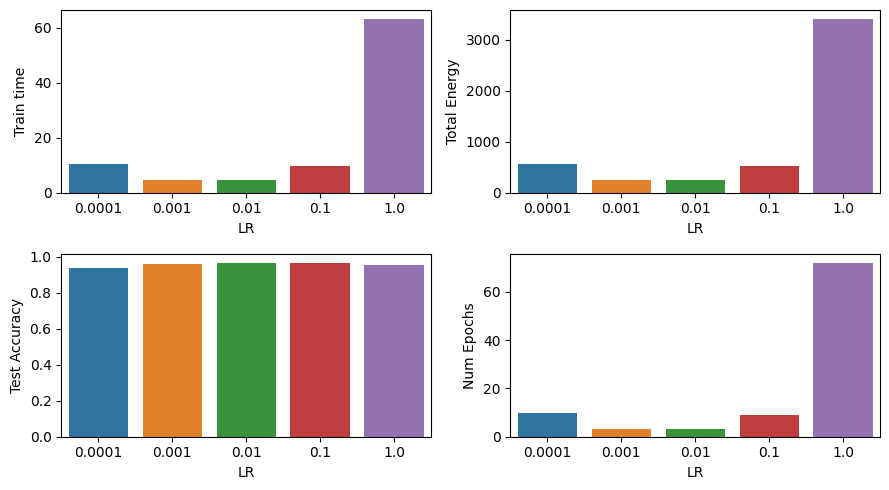
<figcaption aria-hidden="true">png</figcaption>
</figure>

**Comment on the results**: Given that the model is trained to a target validation accuracy, what is the effect of the learning rate on the training process?

Note: because of the stochastic nature of neural network training AND in the compute resource, these measurements can be very “noisy”. Look for overall trends, but don’t be concerned with small differences from one experiment to the next, or with occasional “outlier” results. Also note that if the number of epochs is 500, this is an indication that the target validation accuracy was *not* reached in 500 epochs!

**Comment** Effect of LR:

-   Training time: If the LR is too high, the model does not converge, and the training process stops after hitting the maximum number of iterations. Hence the training time is the highest for these cases. When LR is very low, the convergence occurs very slowly. So the time taken is relatively higher than the case when the LR is ideal.
-   Energy: Same trend as time. More the time, the higher the energy .
-   Test accuracy: If the model converges, the test accuracy reaches the maximum (for LR in {.0001,.001,.01}. For very high LRs, the model does not converge hence the test accuracy is lower.
-   Num epochs: Same trend as time since the batch size is the same.

Now, you will repeat, with a loop over different batch sizes -

``` python
# TODO - iterate over batch size and get TTA/ETA

# default learning rate and batch size -
lr = 0.001
batch_size = 128

metrics_vs_bs = []
for batch_size in [64, 128]:#, 256, 512, 1024, 2048]:

    # TODO - set up model, including appropriate optimizer hyperparameters
    model_test =  get_model()
    opt = optimizers.Adam(learning_rate=lr)
    model_test.compile(optimizer = opt, loss = loss_fn, metrics = ['accuracy'])

    # start measurement
    # if on GPU runtime
    try:
        monitor.begin_window("model_train")
    # if on GPU runtime, but last measurement window is still running
    except ValueError:
        _ = monitor.end_window("model_train")
        monitor.begin_window("model_train")
    # if on CPU runtime
    except NameError:
        start_time = time.time()


    # TODO - fit model on (scaled) training data
    # until specified validation accuracy is achieved (don't use test data!)
    # but stop after 500 epochs even if validation accuracy is not achieved

    hist_test = model_test.fit(Xtr_scale,ytr, batch_size = batch_size, epochs=500,
                               validation_split = 0.2, callbacks=[TrainToAccuracy(threshold=0.95, patience=3)])

    # end measurement
    # if on GPU runtime
    try:
        measurement = monitor.end_window("model_train")
    # if on CPU runtime
    except NameError:
        total_time = time.time() - start_time

    # TODO - evaluate model on (scaled) test data

    test_acc = acc_metric(yts,model_test.predict(Xts_scale))

    # save results in a dictionary
    model_metrics = {
       'batch_size': batch_size,
       'learning_rate': lr,
       'epochs': len(hist_test.history['loss']),
       'test_accuracy': test_acc,
       'total_energy': measurement.total_energy, # if on GPU runtime
       'train_time': measurement.time
    }

    # TODO - append model_metrics dictionary to the metrics_vs_lr list
    metrics_vs_bs.append(model_metrics)
```

    Epoch 1/500
    [1m100/829[0m [32m━━[0m[37m━━━━━━━━━━━━━━━━━━[0m [1m1s[0m 2ms/step - accuracy: 0.5524 - loss: 1.3695

    W0000 00:00:1711942743.264308      94 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m829/829[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 2ms/step - accuracy: 0.8141 - loss: 0.6186

    W0000 00:00:1711942745.264317      96 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m829/829[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 3ms/step - accuracy: 0.8142 - loss: 0.6183 - val_accuracy: 0.9667 - val_loss: 0.1313
    Epoch 2/500
    [1m 93/829[0m [32m━━[0m[37m━━━━━━━━━━━━━━━━━━[0m [1m1s[0m 2ms/step - accuracy: 0.9677 - loss: 0.1306

    W0000 00:00:1711942745.721739      94 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m800/829[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 2ms/step - accuracy: 0.9727 - loss: 0.1115

    W0000 00:00:1711942747.060863      96 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m829/829[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 2ms/step - accuracy: 0.9728 - loss: 0.1109 - val_accuracy: 0.9838 - val_loss: 0.0680
    Epoch 3/500
    [1m 99/829[0m [32m━━[0m[37m━━━━━━━━━━━━━━━━━━[0m [1m1s[0m 2ms/step - accuracy: 0.9842 - loss: 0.0704

    W0000 00:00:1711942747.365184      94 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m816/829[0m [32m━━━━━━━━━━━━━━━━━━━[0m[37m━[0m [1m0s[0m 2ms/step - accuracy: 0.9856 - loss: 0.0617

    W0000 00:00:1711942748.682680      94 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m829/829[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 2ms/step - accuracy: 0.9856 - loss: 0.0616 - val_accuracy: 0.9885 - val_loss: 0.0474
    [1m126/466[0m [32m━━━━━[0m[37m━━━━━━━━━━━━━━━[0m [1m0s[0m 1ms/step

    W0000 00:00:1711942749.158306      94 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m466/466[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 1ms/step
    Epoch 1/500
    [1m 98/415[0m [32m━━━━[0m[37m━━━━━━━━━━━━━━━━[0m [1m0s[0m 2ms/step - accuracy: 0.5639 - loss: 1.3565

    W0000 00:00:1711942751.156427      94 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 3ms/step - accuracy: 0.7519 - loss: 0.8092

    W0000 00:00:1711942752.656289      97 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m3s[0m 5ms/step - accuracy: 0.7522 - loss: 0.8084 - val_accuracy: 0.9546 - val_loss: 0.2088
    Epoch 2/500
    [1m 95/415[0m [32m━━━━[0m[37m━━━━━━━━━━━━━━━━[0m [1m0s[0m 2ms/step - accuracy: 0.9560 - loss: 0.1952

    W0000 00:00:1711942753.055107      97 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9600 - loss: 0.1728 - val_accuracy: 0.9700 - val_loss: 0.1137
    Epoch 3/500
    [1m  1/415[0m [37m━━━━━━━━━━━━━━━━━━━━[0m [1m11s[0m 27ms/step - accuracy: 0.9844 - loss: 0.0813

    W0000 00:00:1711942753.729068      96 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520
    W0000 00:00:1711942753.897306      95 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m415/415[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 2ms/step - accuracy: 0.9747 - loss: 0.1023 - val_accuracy: 0.9833 - val_loss: 0.0748


    W0000 00:00:1711942754.602186      94 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m129/466[0m [32m━━━━━[0m[37m━━━━━━━━━━━━━━━[0m [1m0s[0m 1ms/step

    W0000 00:00:1711942754.930663      95 graph_launch.cc:161] Evict all gpu graphs from executor 0x5b038c5c5520


    [1m466/466[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 1ms/step

Next, you will visualize the results.

**GPU runtime instructions**: Create a figure with four subplots. In each subplot, create a bar plot with batch size on the horizontal axis and (1) Time to accuracy, (2) Energy to accuracy, (3) Test accuracy, (4) Epochs, on the vertical axis on each subplot, respectively. Use an appropriate vertical range for each subplot. Label all axes.

**CPU runtime instructions**: Create a figure with three subplots. In each subplot, create a bar plot with batch size on the horizontal axis and (1) Time to accuracy, (2) Test accuracy, (3) Epochs, on the vertical axis on each subplot, respectively. Use an appropriate vertical range for each subplot. Label all axes.

``` python
# TODO - visualize effect of varying batch size, when training to a target accuracy
plt.figure(figsize = (9,5))
batch_ls = [_['batch_size'] for _ in metrics_vs_bs]

plt.subplot(2,2,1)
time_ = [_['train_time'] for _ in metrics_vs_bs]

sns.barplot(x=batch_ls, y=time_)
plt.xlabel('Batch Size');
plt.ylabel('Train time')

plt.subplot(2,2,2)
energy_ = [_['total_energy'] for _ in metrics_vs_bs]

sns.barplot(x=batch_ls, y=energy_)
plt.xlabel('Batch Size');
plt.ylabel('Total Energy')

plt.subplot(2,2,3)
test_acc_ = [_['test_accuracy'].cpu().numpy() for _ in metrics_vs_bs]

sns.barplot(x=batch_ls, y=test_acc_)
plt.xlabel('Batch Size');
plt.ylabel('Test Accuracy')

plt.subplot(2,2,4)
nepochs_ = [_['epochs'] for _ in metrics_vs_bs]

sns.barplot(x=batch_ls, y=nepochs_)
plt.xlabel('Batch Size');
plt.ylabel('Num Epochs')
plt.tight_layout()
```

    /opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
      order = pd.unique(vector)
    /opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
      order = pd.unique(vector)
    /opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
      order = pd.unique(vector)
    /opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
      order = pd.unique(vector)

<figure>
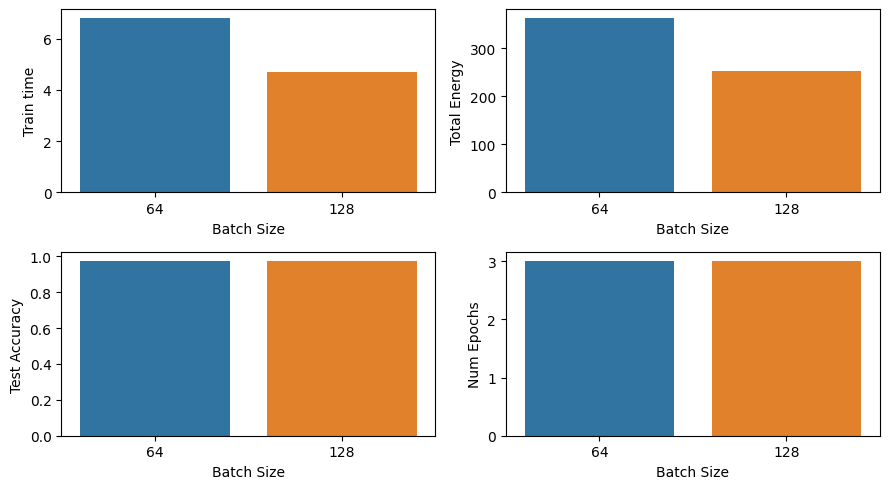
<figcaption aria-hidden="true">png</figcaption>
</figure>

**Comment on the results**: Given that the model is trained to a target validation accuracy, what is the effect of the batch size on the training process?

Note: because of the stochastic nature of neural network training AND in the compute resource, these measurements can be very “noisy”. Look for overall trends, but don’t be concerned with small differences from one experiment to the next, or with occasional “outlier” results. Also note that if the number of epochs is 500, this is an indication that the target validation accuracy was *not* reached in 500 epochs!

**Comment** Effect of LR:

-   Training time: If the Batch size is too high, the training time is less since less number of batches per epoch. Time taken to work on a batch is constant because of parallelism. Model stops early for batch size 128 and 512 hence, the plot does not have a monotonic trend.
-   Energy: Same trend as time. More the time, the higher the energy.
-   Test accuracy: For this dataset, it appears as if 2048 is the ideal hyperparameter for training.
-   Num epochs: The model hits early stopping criteria for batch size 128 and 512, for the rest, the model hit maximum number of iterations.